# Evaluation of different embedings by comparing a clustering to the primary categories 

## Method
We use kmedoids with the **cosine distance** to cluster the embeddings.
We set the number of clusters to be equal to the number of primary categories.

## Motivations
We use cosine distance because it normalises vectors and by doing so, we make sure that the size of the article doesn't act as a confounding factor.
We use kmedoids to extract meaning for each cluster by looking at the name and primary category of the center.

In [39]:
import pandas as pd
from src.semantic.perform_clustering import run_kimchi_cos
import matplotlib.pyplot as plt
import colorsys
import numpy as np

category_file = './/data//original_dataset//wikispeedia_paths-and-graph//categories.tsv'   

category_df = pd.read_csv(category_file, sep='\t', skiprows=12,header=None)
category_df.columns = ['concept','category']
category_df['primary_category'] = category_df['category'].apply(lambda x: x.split('.')[1])
category_dict = dict(zip(category_df['concept'], category_df['primary_category']))

models = ['MiniLM_L6_v2', 'mpnet_base_v2', 'roberta']

model_clustering_dfs = []
for model_name in models:
    model_file = f'.//data//semantic//output//embeddings//{model_name}//embeddings.pkl'
    model_cluster = run_kimchi_cos(model_file, category_file)
    model_cluster['center_category'] = model_cluster['center_name'].map(category_dict)
    model_cluster['members_categories'] = model_cluster['member_names'].apply(
        lambda members: [category_dict.get(member, 'Unknown') for member in members]
    )
    model_clustering_dfs.append(model_cluster)


for i, clustering_df in enumerate(model_clustering_dfs): 
    print(models[i])
    print(clustering_df[['center_name', 'center_category', 'cluster_size']])

MiniLM_L6_v2
                   center_name center_category  cluster_size
0               Elephant_shrew         Science           531
1                Protoceratops         Science           142
2                   Dimetrodon         Science           159
3                     Devonian       Geography           193
4                    Stone_Age         History           227
5                      Geology       Geography           422
6                  Mesopotamia         History           256
7                      Assyria         History           294
8                      Biology         Science           432
9                        Earth         Science           320
10             Akkadian_Empire         History           376
11  History_of_the_Netherlands         History           385
12                 8th_century         History           304
13                    Svalbard       Geography           439
14                     Permian       Geography           124
mpnet_base_

## Observations 
Most of the cluster centers are related to Science. This is not very surprinsing because, science is the biggest primary category : 

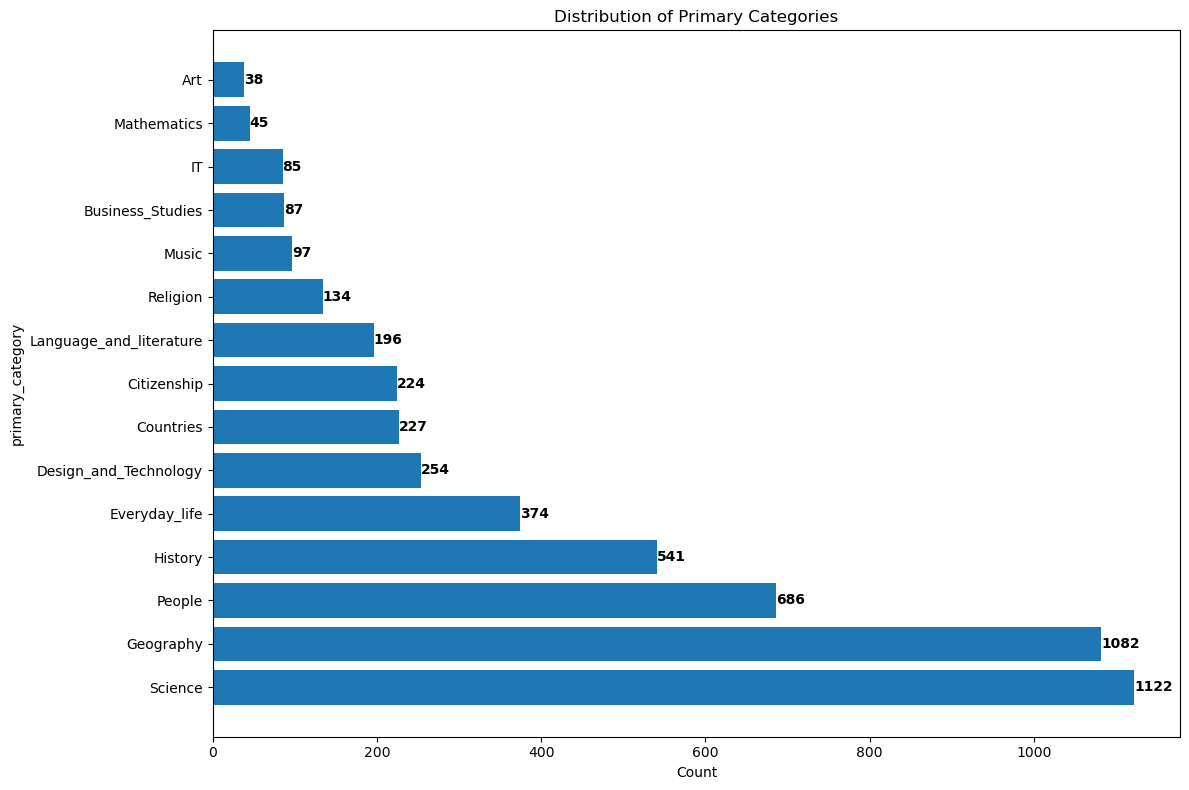

In [40]:
def plot_distribution(df, column, title=None, figsize=(12, 8), top_n=None, sort_by='value'):
    """
    Plot the distribution of values in a specified column of a DataFrame.
    
    Parameters:
    - df: pandas DataFrame
    - column: str, the name of the column to plot
    - title: str, optional, the title of the plot
    - figsize: tuple, optional, the size of the figure (width, height)
    - top_n: int, optional, limit to top N categories (by frequency or alphabetically)
    - sort_by: str, optional, 'value' to sort by frequency (default) or 'index' to sort alphabetically
    """
    value_counts = df[column].value_counts()
    if sort_by == 'index':
        value_counts = value_counts.sort_index()
    if top_n is not None:
        value_counts = value_counts.nlargest(top_n) if sort_by == 'value' else value_counts.head(top_n)

    plt.figure(figsize=figsize)
    bars = plt.barh(value_counts.index, value_counts.values)
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
                 ha='left', va='center', fontweight='bold')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.title(title or f'Distribution of {column}')
    plt.tight_layout()
    plt.show()

plot_distribution(category_df, 'primary_category', title='Distribution of Primary Categories')


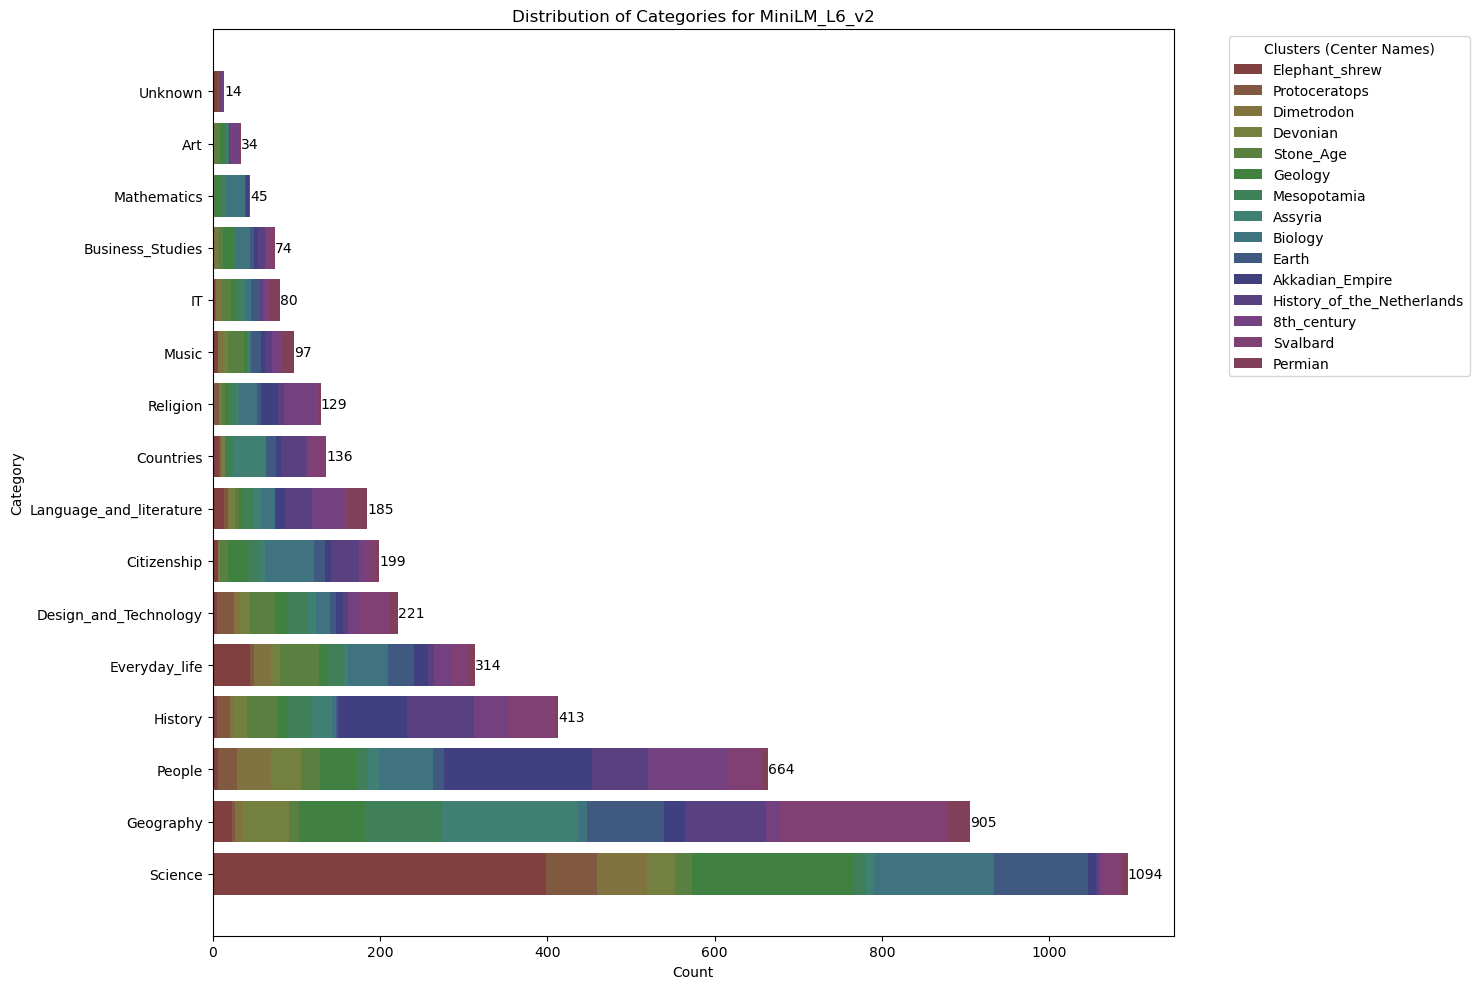

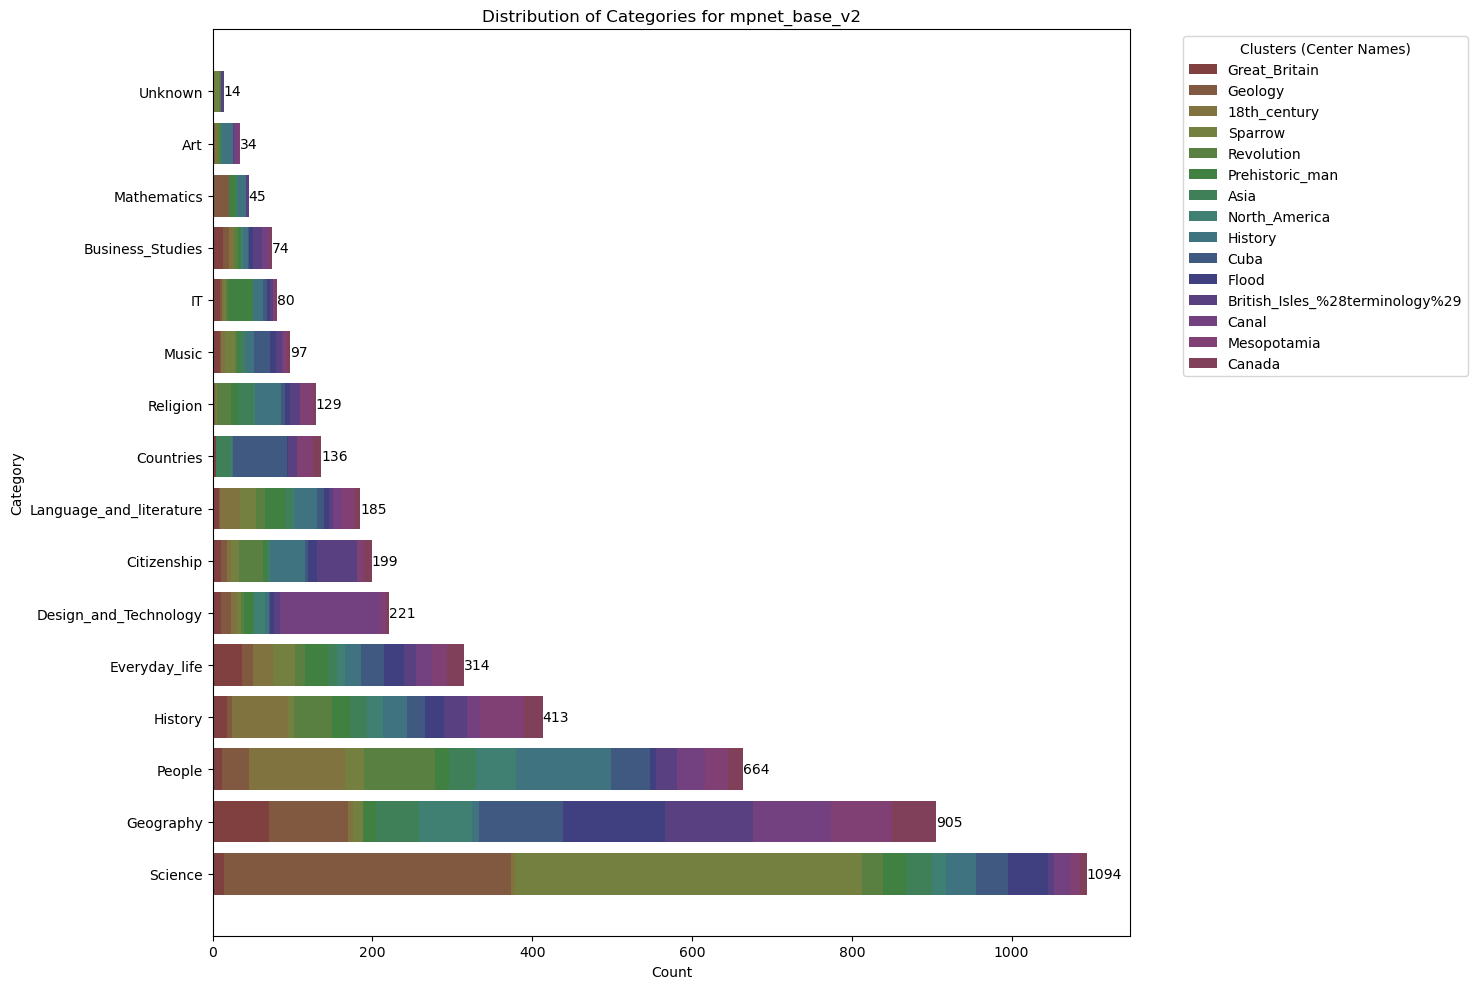

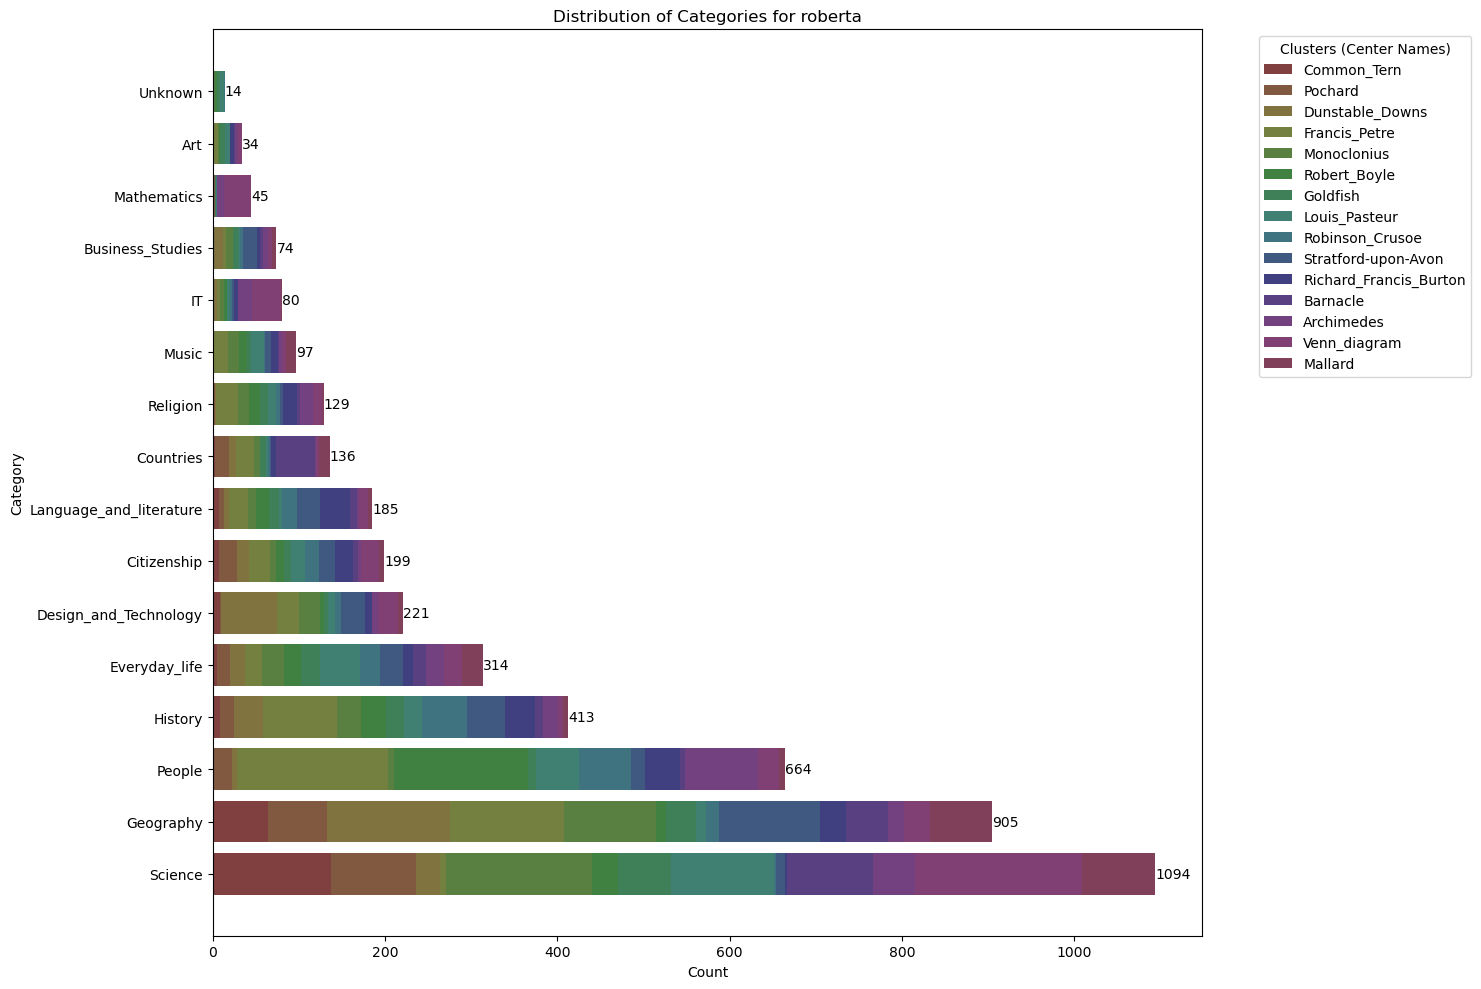

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import colorsys

def plot_distribution_stacked(df, column, members_column, title=None, figsize=(15, 10)):
    """
    Plot the distribution of values with each cluster having a unique color,
    sorted by total count and using center_name for cluster labels.
    
    Parameters:
    - df: pandas DataFrame with clustering results
    - column: str, column containing center categories
    - members_column: str, column containing lists of member categories
    - title: str, optional title for the plot
    - figsize: tuple, size of the figure
    """
    # Flatten member categories and count occurrences
    all_categories = df[members_column].explode().value_counts().index
    
    # Generate a color palette with a distinct color for each cluster
    def generate_distinct_colors(n):
        HSV_tuples = [(x*1.0/n, 0.5, 0.5) for x in range(n)]
        return list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    
    colors = generate_distinct_colors(len(df))
    
    # Prepare the plot
    plt.figure(figsize=figsize)
    
    # Track the bottom of each bar for stacking
    bottom = np.zeros(len(all_categories))
    
    # Plot each cluster with a different color
    for i, (_, row) in enumerate(df.iterrows()):
        center_name = row['center_name']
        member_categories = row[members_column]
        
        # Count category occurrences for this cluster
        category_counts = pd.Series(member_categories).value_counts()
        
        # Create a bar for each category in this cluster
        cluster_bars = []
        for cat in all_categories:
            count = category_counts.get(cat, 0)
            bar = plt.barh(cat, count, left=bottom[all_categories.get_loc(cat)], 
                           color=colors[i], label=center_name)
            cluster_bars.append(bar)
            bottom[all_categories.get_loc(cat)] += count
    
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.title(title or 'Distribution of Categories Across Clusters')
    
    # Add count labels
    for cat_idx, cat in enumerate(all_categories):
        plt.text(bottom[cat_idx], cat_idx, f'{bottom[cat_idx]:.0f}', 
                 va='center', ha='left')
    
    # Customize legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title='Clusters (Center Names)', 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Usage
for i, model_cluster in enumerate(model_clustering_dfs):
    plot_distribution_stacked(model_cluster, 'center_category', 'members_categories', 
                      title=f'Distribution of Categories for {models[i]}')


## Observations : 
We can see that clusters do not match primary categories at all.